In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
#function to tag 'LD' and 'HD' phases
def tag_phases(x):
    if x.base.num_phases_max !=2:
        raise ValueError('bad tag function')
        

    if x.nphase==1:
        if x[0].density<0.5:
            return np.array([0])
        else:
            return np.array([1])
    
    elif x.nphase==2:
        return np.argsort(x.argmax[0])
    else:
        raise ValueError('bad nphase')
    
            

In [4]:
import lnPi

# create a reference lnPi_phases for bulk case

In [93]:
#from data
data = np.loadtxt('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat')


lnpi_bulk = lnPi.lnPi_phases.from_data(data,mu=-8.6160,volume=729.00,beta=1.0/0.7,
                                       num_phases_max=2,                                       
                                       argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                       ftag_phases=tag_phases)


# or
# lnPi = 

In [94]:
data

array([[   0.        ,  -20.71351647],
       [   1.        ,  -19.80847807],
       [   2.        ,  -19.57175377],
       ..., 
       [ 658.        ,  -70.2838598 ],
       [ 659.        ,  -72.8806118 ],
       [ 660.        ,  -75.4992428 ]])

In [98]:
#from file
lnpi_bulk = lnPi.lnPi_phases.from_file('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat',
                                       mu=-8.6160,volume=729.00,beta=1.0/0.7,
                                       num_phases_max=2,                                       
                                       argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                       ftag_phases=tag_phases)

In [108]:
val = data[:,1]
val

array([ -1.80616103e+01,  -1.71565719e+01,  -1.69198476e+01,
        -1.70637165e+01,  -1.74704027e+01,  -1.80750106e+01,
        -1.88368841e+01,  -1.97280741e+01,  -2.07278385e+01,
        -2.18209366e+01,  -2.29936916e+01,  -2.42359998e+01,
        -2.55399163e+01,  -2.68979013e+01,  -2.83040303e+01,
        -2.97525683e+01,  -3.12407623e+01,  -3.27628343e+01,
        -3.43157913e+01,  -3.58968853e+01,  -3.75017173e+01,
        -3.91293323e+01,  -4.07755303e+01,  -4.24384293e+01,
        -4.41166313e+01,  -4.58071703e+01,  -4.75078503e+01,
        -4.92168983e+01,  -5.09325973e+01,  -5.26530243e+01,
        -5.43759113e+01,  -5.60996473e+01,  -5.78225723e+01,
        -5.95419703e+01,  -6.12555133e+01,  -6.29603213e+01,
        -6.46550143e+01,  -6.63370813e+01,  -6.80033343e+01,
        -6.96528953e+01,  -7.12826143e+01,  -7.28895493e+01,
        -7.44720763e+01,  -7.60303163e+01,  -7.75627583e+01,
        -7.90689543e+01,  -8.05505103e+01,  -8.20070803e+01,
        -8.34392963e+01,

In [110]:
#another way
lnpi_bulk = lnPi.lnPi(data = val,mask=False,num_phases_max=2,mu=-8.6160, volume=729., beta=1./0.7).to_phases(
    argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                   ftag_phases=tag_phases)

## create a collection

In [41]:
C = lnPi.lnPi_collection.from_mu(lnpi_bulk,[None],np.linspace(-12,-5,20))

In [42]:
#set spinodal/binodal
C.get_spinodals()
C.get_binodals()
#sort by mu
C.sort_by_mu(inplace=True)

In [43]:
def make_Omega_vs_mu_phase_plot(C,spin=None,bino=None,ax=None,ax_labels=True):
    if ax is None:
        fig,ax = plt.subplots()
        
    x = C.mus[:,0]
    y = C.Omegas_phaseIDs()

    if spin is None:
        spin = C.spinodals
    s0,s1 = spin
    
    if bino is None:
        bino = C.binodals[0]

    l0,=plt.plot(x,y[:,0],label='phase0')
    l1,=plt.plot(x,y[:,1],label='phase1')
    plt.plot(s0.mu,s0.Omegas_phaseIDs()[0],'o',color=l0.get_color())
    plt.plot(s1.mu,s1.Omegas_phaseIDs()[1],'o',color=l1.get_color())
    plt.plot(bino.mu,bino.Omegas_phaseIDs()[0],'s',color='k')

    if ax_labels:
        ax.set_ylabel(r'$\Omega^{ex}$')
        ax.set_xlabel(r'$\mu$')
    

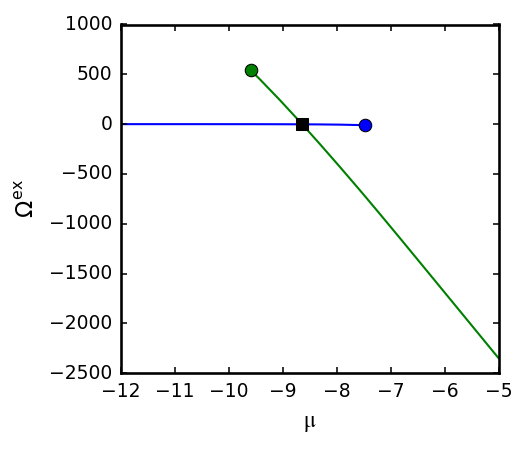

In [44]:
#plot
make_Omega_vs_mu_phase_plot(C)

# bulk 065

In [45]:
lnpi_bulk = lnPi.lnPi_phases.from_file('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat',mu=-4.453015418106743E+00,
                               volume=1000.0E0,num_phases_max=2,beta=1./0.65000E0,ZeroMax=True,fill_value=np.nan,
                                      argmax_kwargs=dict(min_distance=[5,10,20,40]),
                                ftag_phases=tag_phases)

In [46]:
Cbulk = lnPi.lnPi_collection.from_mu(lnpi_bulk,[None],np.linspace(-7,.2,50))
Cbulk.get_spinodals()
Cbulk.get_binodals()

Cbulk.sort_by_mu(inplace=True)

In [40]:
#saturation pressure
psat = (-Cbulk.binodals[0].Omegas_phaseIDs()/Cbulk[0].base.volume)[0]

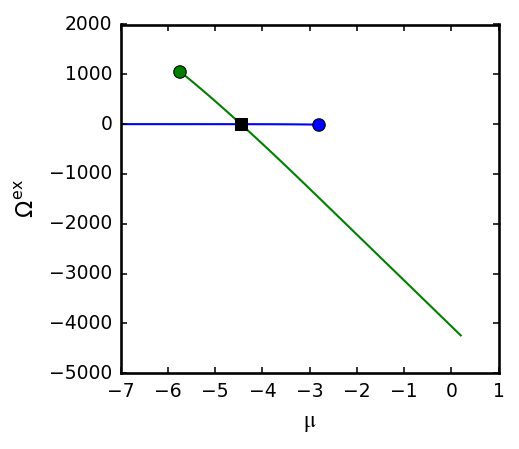

In [20]:
make_Omega_vs_mu_phase_plot(Cbulk)

# confined

In [21]:
def tag_phases_conf(x):
    if x.base.num_phases_max !=2:
        raise ValueError('bad tag function')
        
    L = []
    for p in x.phases:
        if p.density<0.5:
            val = 0
        else:
            val = 1
        L.append(val)
        
    L = np.array(L)
    


    return L

In [22]:
#make up a volume

lnpi_conf = lnPi.lnPi_phases.from_file('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',
                                mu=-0.500000E+01,volume=7000.,beta=1./0.65000E0,
                                num_phases_max=2,ZeroMax=True,fill_value=np.nan,
                                      argmax_kwargs=dict(min_distance=[5,10,20,40]),ftag_phases=tag_phases_conf,
                                build_kwargs=dict(merge_phaseIDs=True))

In [23]:
Cconf = lnPi.lnPi_collection.from_mu(lnpi_conf,[None],np.linspace(-5.2,-5.0,50)) #np.linspace(-8,-5,10)
Cconf.get_spinodals()
Cconf.get_binodals()
Cconf.sort_by_mu(inplace=True)

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


(-5.14, -5.09)

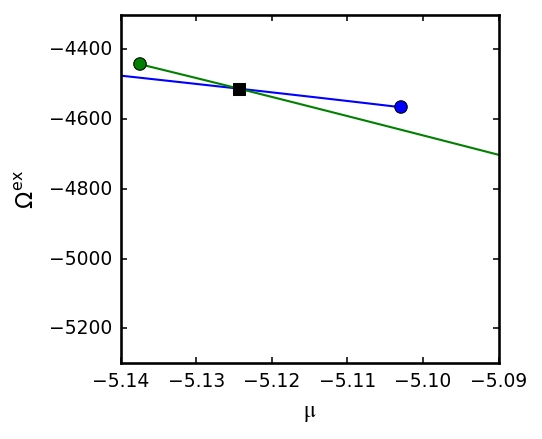

In [24]:
make_Omega_vs_mu_phase_plot(Cconf.merge_phases(efac=0.9),Cconf.spinodals,Cconf.binodals[0])


ax=plt.gca()
ax.set_xlim(-5.14,-5.09)

In [34]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


In [25]:
#make isotherm

In [31]:
a = np.linspace(-20,Cconf.spinodals[1].mu[0],100)
b = np.linspace(Cconf.spinodals[1].mu[0],Cconf.spinodals[0].mu[0],100)
c = np.linspace(Cconf.spinodals[0].mu[0],Cbulk.binodals[0].mu[0],100)
mus = np.concatenate((a,b,c))

In [32]:
Cb = lnPi.lnPi_collection.from_mu(lnpi_bulk,[None],x=mus)

Cc = lnPi.lnPi_collection.from_mu_iter(lnpi_conf,Cb.mus)

In [33]:
P = (-Cb.Omegas_phaseIDs()[:,0])/Cb[0].base.volume # + Cb.Naves_phaseIDs[:,0,0]*0.65000)/Cb[0].base.volume

#scale pressure
P = P/psat
#get 'density'
rho = Cc.Naves_phaseIDs[:,:,0]

(0, 1.0)

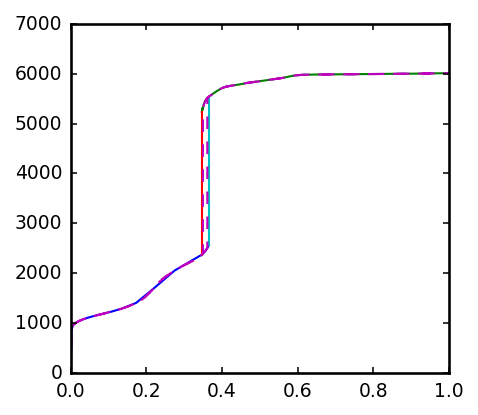

In [35]:
fig,ax = plt.subplots()

plt.plot(P,rho[:,0])
plt.plot(P,rho[:,1])

plt.plot([P[100],P[100]],[rho[100,0],rho[100,1]])
plt.plot([P[200],P[200]],[rho[200,0],rho[200,1]])


plt.plot(df.pscaled,df.rho,'--')
plt.gca().set_xlim(0,1.0)
#plt.gca().set_xlim(0.3,0.5)

(0.3, 0.5)

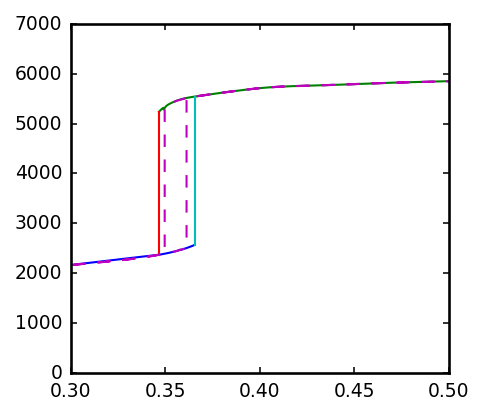

In [36]:
fig,ax = plt.subplots()

plt.plot(P,rho[:,0])
plt.plot(P,rho[:,1])

plt.plot([P[100],P[100]],[rho[100,0],rho[100,1]])
plt.plot([P[200],P[200]],[rho[200,0],rho[200,1]])


plt.plot(df.pscaled,df.rho,'--')
#plt.gca().set_xlim(0,1.0)
plt.gca().set_xlim(0.3,0.5)